In [1]:
import pandas as pd
import numpy as np
import datetime 
import statsmodels.api as sm

import plotly.plotly as py
import plotly.graph_objs as go
import plotly.tools as tls
from plotly.graph_objs import *
import plotly.graph_objs as go
import cufflinks as cf

py.sign_in('DemoAccount','2qdyfjyr7o')

## 第一节：Fama-French三因子模型

<font size = 3 face = '宋体'>
Fama和French提出了一个和sharpe风格分析在理念伤非常接近的业绩分析方法，他们提出了用如下回归方程进行业绩分析。  
$$r_p(t)= \alpha_p + \beta\cdot r_b(t) + \beta \cdot SMB(t) + \beta_v \cdot HML(t) + \epsilon_p(t) $$这看起来像是增加了额外两项的标准CAPM回归。SMB(t)是一个买入小盘股卖出大盘股的组合收益率。HML(t)是一个买入高净市率股票卖空低净市率股票的投资组合收益率。Fema和Franch的方法在两个维度进行了控制，同时使用了回归的方法。
</font>

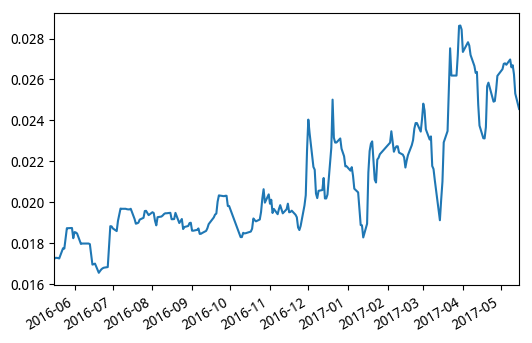

In [2]:
risk_free_rate = get_yield_curve(start_date='20160514', end_date='20170515', tenor=None, country='cn')['0S']
risk_free_rate.plot()#隔夜逆回购

In [3]:
# 拿到基准收益率
index_change_rate = get_price_change_rate('000001.XSHG',start_date='20160514', end_date='20170515')
# 拿到无风险利率,隔夜国债
risk_free_rate = get_yield_curve(start_date='20160514', end_date='20170515', tenor=None, country='cn')['0S']
# 反年化处理,每天的利息
risk_free_rate = (risk_free_rate+1)**(1/244)-1
# 取与基准相同的交易日
risk_free_rate = risk_free_rate[list(index_change_rate.index)]#
price_change_rate = pd.DataFrame()
price_change_rate['risk_free_rate'] = risk_free_rate
price_change_rate['000001.XSHG'] = index_change_rate
price_change_rate.head()

,risk_free_rate,000001.XSHG
2016-05-16,0.00007,0.008402
2016-05-17,0.00007,-0.002518
2016-05-18,0.00007,-0.012719
2016-05-19,0.00007,-0.000217
2016-05-20,0.00007,0.006618


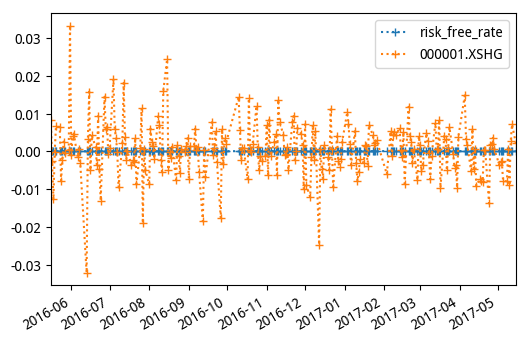

In [4]:
price_change_rate.plot(ls=':',marker='+')

In [5]:
# 取2016-05-15的估值数据作为SMB和HML的计算标准
all_stocks_value = get_fundamentals(
    query(
        fundamentals.eod_derivative_indicator.pb_ratio,
        fundamentals.eod_derivative_indicator.market_cap)
    , '2016-05-15', interval = '1d' ,report_quarter = False)
all_stocks_value

<class 'pandas.core.panel.Panel'>
Dimensions: 2 (items) x 1 (major_axis) x 2848 (minor_axis)
Items axis: pb_ratio to market_cap
Major_axis axis: 2016-05-13 00:00:00 to 2016-05-13 00:00:00
Minor_axis axis: 000005.XSHE to 002797.XSHE

In [6]:
all_stocks_value = all_stocks_value.iloc[:,0,:]
all_stocks_value.head()

,pb_ratio,market_cap
000005.XSHE,6.5446,7.47327e+09
600602.XSHG,3.8168,1.26845e+10
600651.XSHG,3.1455,1.02955e+10
600652.XSHG,5.4917,1.14247e+10
600654.XSHG,8.3436,2.46982e+10


In [7]:
all_stocks_value['bp_ratio'] = 1/all_stocks_value['pb_ratio']#pb
del all_stocks_value['pb_ratio']
all_stocks_value = all_stocks_value.dropna(how = 'any')
all_stocks_value.head()

,market_cap,bp_ratio
000005.XSHE,7.47327e+09,0.152798
600602.XSHG,1.26845e+10,0.262
600651.XSHG,1.02955e+10,0.317914
600652.XSHG,1.14247e+10,0.182093
600654.XSHG,2.46982e+10,0.119852


In [8]:
# 拿到所有股票的日收益率数据
all_price_change_rate = get_price_change_rate(list(all_stocks_value.index),start_date='20160514', end_date='20170515')
all_price_change_rate.head()

order_book_id,000001.XSHE,000002.XSHE,000004.XSHE,000005.XSHE,000006.XSHE,000007.XSHE,000008.XSHE,000009.XSHE,000010.XSHE,000011.XSHE,...,603968.XSHG,603969.XSHG,603979.XSHG,603988.XSHG,603989.XSHG,603993.XSHG,603996.XSHG,603997.XSHG,603998.XSHG,603999.XSHG
date,,,,,,,,,,,,,,,,,,,,,
2016-05-16,0.000966,0.0,0.0,-0.004250,0.015193,0.0,0.002573,0.027687,0.013698,0.010726,...,0.021104,0.006473,0.011156,0.018755,0.017122,0.0,-0.005135,0.036574,0.022205,0.025498
2016-05-17,-0.005792,0.0,0.0,-0.004267,0.004082,0.0,-0.023952,-0.003169,0.001228,0.024489,...,-0.010333,-0.008040,-0.008385,-0.023413,-0.002619,0.0,0.059784,-0.013783,-0.014982,-0.002122
2016-05-18,0.000000,0.0,0.0,-0.044286,-0.025745,0.0,-0.041192,-0.037362,-0.058895,-0.035858,...,-0.083936,-0.030794,-0.027147,-0.041187,-0.037884,0.0,-0.095374,-0.036890,-0.062358,-0.035855
2016-05-19,-0.004854,0.0,0.0,0.004485,0.001391,0.0,0.003656,0.002478,-0.006519,0.001655,...,-0.001315,0.010869,0.001830,0.000854,0.005848,0.0,0.100046,0.005802,0.008111,0.006618
2016-05-20,0.004878,0.0,0.0,0.013393,0.002778,0.0,-0.002732,0.009884,0.001313,0.005774,...,-0.034679,0.010051,0.009589,-0.008115,0.021707,0.0,0.099917,0.017312,0.006437,0.012523


In [9]:
# 去除nan要去除每行的每列的nan
test = all_price_change_rate.dropna(how = 'any',axis=1)
test.head()

order_book_id,000001.XSHE,000002.XSHE,000004.XSHE,000005.XSHE,000006.XSHE,000007.XSHE,000008.XSHE,000009.XSHE,000010.XSHE,000011.XSHE,...,603968.XSHG,603969.XSHG,603979.XSHG,603988.XSHG,603989.XSHG,603993.XSHG,603996.XSHG,603997.XSHG,603998.XSHG,603999.XSHG
date,,,,,,,,,,,,,,,,,,,,,
2016-05-16,0.000966,0.0,0.0,-0.004250,0.015193,0.0,0.002573,0.027687,0.013698,0.010726,...,0.021104,0.006473,0.011156,0.018755,0.017122,0.0,-0.005135,0.036574,0.022205,0.025498
2016-05-17,-0.005792,0.0,0.0,-0.004267,0.004082,0.0,-0.023952,-0.003169,0.001228,0.024489,...,-0.010333,-0.008040,-0.008385,-0.023413,-0.002619,0.0,0.059784,-0.013783,-0.014982,-0.002122
2016-05-18,0.000000,0.0,0.0,-0.044286,-0.025745,0.0,-0.041192,-0.037362,-0.058895,-0.035858,...,-0.083936,-0.030794,-0.027147,-0.041187,-0.037884,0.0,-0.095374,-0.036890,-0.062358,-0.035855
2016-05-19,-0.004854,0.0,0.0,0.004485,0.001391,0.0,0.003656,0.002478,-0.006519,0.001655,...,-0.001315,0.010869,0.001830,0.000854,0.005848,0.0,0.100046,0.005802,0.008111,0.006618
2016-05-20,0.004878,0.0,0.0,0.013393,0.002778,0.0,-0.002732,0.009884,0.001313,0.005774,...,-0.034679,0.010051,0.009589,-0.008115,0.021707,0.0,0.099917,0.017312,0.006437,0.012523


In [10]:
all_price_change_rate.columns#股票

Index(['000001.XSHE', '000002.XSHE', '000004.XSHE', '000005.XSHE',
       '000006.XSHE', '000007.XSHE', '000008.XSHE', '000009.XSHE',
       '000010.XSHE', '000011.XSHE',
       ...
       '603968.XSHG', '603969.XSHG', '603979.XSHG', '603988.XSHG',
       '603989.XSHG', '603993.XSHG', '603996.XSHG', '603997.XSHG',
       '603998.XSHG', '603999.XSHG'],
      dtype='object', name='order_book_id', length=2835)

In [11]:
stock_need_drop = list(set(all_price_change_rate.columns).difference(set(test.columns)))
stock_need_drop

['000748.XSHE', '600005.XSHG']

<font size = 3 face = '宋体'>
&nbsp;&nbsp;有两支股票的日收益率数据含有nan，'000748.XSHE', '600005.XSHG'。查询资料发现：  
&nbsp;&nbsp;电脑(000066)和长城信息(000748)3月9日发布重大资产重组公告,长城电脑拟换股吸收合并长城信息,交易完成后,长城电脑将作为存续方,长城信息将注销法人资格,也将退市。  
&nbsp;&nbsp;武钢股份(600005)此前发布公告称,经上交所上市委员会审核,决定对武钢股份予以终止上市,终止上市日期为2月14日。  
&nbsp;&nbsp;两支含有nan的股票都退市，故没有数据。
</font>

In [12]:
# 在估值数据中将上述两支股票删除
all_stocks_value = all_stocks_value.T
for stock in stock_need_drop:
    del all_stocks_value[stock]
all_stocks_value = all_stocks_value.T

<font size = 3 face = '宋体'>
以市值中位数为界将所有股票分为两类----S类（small，小盘股）和B类（big，大盘类）。同时对所有股票按照净市率排序。最后30%定义为L类，中间40%定义为M类，最高30%定义为H类。两个维度共计6类，计算6类的加权收益率。
</font>

In [13]:
copy = all_stocks_value.iloc[:,:]
all_stocks_value = all_stocks_value.sort_values('market_cap') #市值升序排布
S = all_stocks_value.index[:int(len(all_stocks_value.index)/2)]
B = all_stocks_value.index[int(len(all_stocks_value.index)/2):]
all_stocks_value = all_stocks_value.sort_values('bp_ratio') #净市率升序排列
L = all_stocks_value.index[:int(len(all_stocks_value.index)*0.3)]
M = all_stocks_value.index[int(len(all_stocks_value.index)*0.3):int(len(all_stocks_value.index)*0.7)]
H = all_stocks_value.index[int(len(all_stocks_value.index)*0.7):]

In [35]:
portfolio = {}#求出来并集
portfolio['SL'] = list(set(S).intersection(set(L)))
portfolio['SM'] = list(set(S).intersection(set(M)))
portfolio['SH'] = list(set(S).intersection(set(H)))
portfolio['BL'] = list(set(B).intersection(set(L)))
portfolio['BM'] = list(set(B).intersection(set(M)))
portfolio['BH'] = list(set(B).intersection(set(H)))

In [15]:
# 市值加权求出每个类别的日收益率时间序列
portfolio_return = {}
for por in portfolio:#6组合，
    portfolio_return[por] = 0#组合 returns is 0
    for stock in portfolio[por]:##stocks,,,,
        #test all stocks returns
        portfolio_return[por] += all_stocks_value['market_cap'][stock]*test[stock]#市值*收益率？？
        #下边除以加权系数了
    portfolio_return[por] = portfolio_return[por]/np.sum(all_stocks_value['market_cap'][portfolio[por]])

In [16]:
SMB = (portfolio_return['SL']+portfolio_return['SM']+portfolio_return['SH'])/3-(portfolio_return['BL']+portfolio_return['BM']+portfolio_return['BH'])/3
HML = (portfolio_return['SH']+portfolio_return['BH'])/2-(portfolio_return['SL']+portfolio_return['BL'])/2

In [17]:
Rb = price_change_rate['000001.XSHG']-price_change_rate['risk_free_rate']

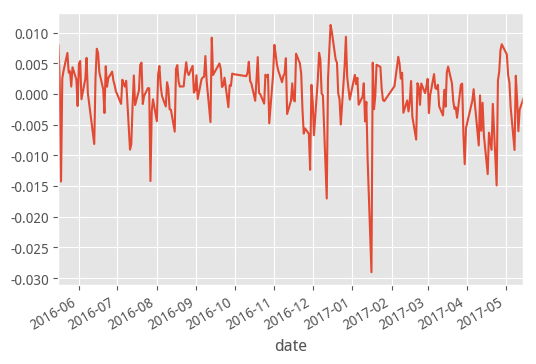

In [37]:
SMB.plot()

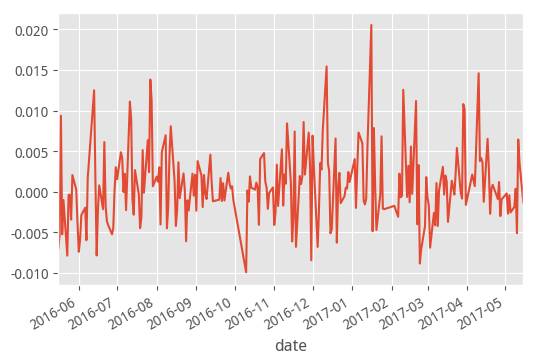

In [38]:
HML.plot()

In [43]:
(SMB>0).sum()/len(SMB)

0.61728395061728392

In [45]:
(HML>0).sum()/len(HML)

0.53086419753086422

In [47]:
HML.min()

-0.0099157251578140138

In [49]:
(1+HML).prod()

1.1871402297887208

<font size = 3 face = '宋体'>投资组合介绍;  
在2016-05-12平均买入去除停牌的股票中市值最小的20支股票。

In [18]:
# 构建组合
q = query(
            fundamentals.eod_derivative_indicator.market_cap,
        ).order_by(
            fundamentals.eod_derivative_indicator.market_cap.asc()
        ).limit(21)
pa = get_fundamentals(q,entry_date = '20160512')
stocks = list(pa.major_xs(pa.major_axis[0]).index)
stocks.remove('600656.XSHG')
# 我们拥有200万资金，计算买入时各股的量，分摊到各股每股10万
price = np.array(get_price(stocks,start_date='20160512', end_date='20170515',fields = 'close'))
# 最小买入一手,计算买入的量
position = np.array(1000/price[0],dtype=int)*100
# 计算剩余现金
cash = 2e6-(price[0]*position).sum()

portfolio_value = (price*position).sum(axis = 1)+cash
# np.diff(portfolio_value)后一天组合总价值减去前一天，得到新的序列.然后用差值依次除以前一天的值，求得日收益率序列
portfolio_value_rate = (np.diff(portfolio_value)/(portfolio_value[:-1]))[1:]
portfolio_value_rate

array([ 0.04690176,  0.00826282, -0.02241415,  0.03122727,  0.03896055,
        0.0363623 ,  0.0057301 ,  0.00595328,  0.01073387, -0.00453721,
        0.00028715,  0.04368306,  0.00901098,  0.01761658,  0.00756529,
        0.0061413 ,  0.00794898, -0.00466621, -0.06015439,  0.00636494,
        0.03680521,  0.00244591,  0.01676524,  0.00397737, -0.00014629,
        0.00964465, -0.00050164, -0.00938068,  0.02654241,  0.00940173,
        0.02530033, -0.00579989,  0.01571037,  0.03436924,  0.01746873,
       -0.0019608 ,  0.00388429, -0.01320044, -0.03841505,  0.01614038,
        0.00296689,  0.00659967,  0.00394035, -0.01939202,  0.00254277,
        0.00196447, -0.01378129, -0.00854916, -0.00800506,  0.01581144,
       -0.058468  ,  0.00561951, -0.0057696 , -0.03025341,  0.02275274,
        0.01823169,  0.00014883, -0.00404677,  0.00897074,  0.01700534,
       -0.00093012, -0.01713266,  0.01166762,  0.02811279,  0.00815158,
        0.02077147,  0.01349679, -0.00213392, -0.02615654,  0.01

<font size = 3 face = '宋体'>600656.XSHG在2016-05-12当日处于停牌状态

In [19]:
Rp = pd.Series(portfolio_value_rate,index = price_change_rate.index)-price_change_rate['risk_free_rate']

<font size = 3 face = '宋体'>开始做回归

In [20]:
X = pd.DataFrame()
X['Rb'] = np.array(Rb)
X['SMB'] = np.array(SMB)
X['HML'] = np.array(HML)
X = sm.add_constant(X)
Y = np.array(Rp)

In [21]:
est=sm.OLS(Y,X).fit()
print(est.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.768
Model:                            OLS   Adj. R-squared:                  0.765
Method:                 Least Squares   F-statistic:                     264.2
Date:                Tue, 26 Sep 2017   Prob (F-statistic):           1.37e-75
Time:                        09:32:47   Log-Likelihood:                 843.56
No. Observations:                 243   AIC:                            -1679.
Df Residuals:                     239   BIC:                            -1665.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          0.0015      0.001      3.072      0.0

In [22]:
est.params

const    0.001540
Rb       1.003847
SMB      1.225742
HML     -0.716755
dtype: float64

<font size = 3 face = '宋体'>
上表主要看coef和t值。
1、SMB大于0，和过去的事实符合，小盘股具有较好的收益率  
2、HML小于0，说明bp大的组合（即pb较小的组合）的组合为负的权重，价值投资不能片面追求较小的pb  
3、t的绝对值大于2，我们一般认为系数显著。  
$$Rp = 0.0015+1.0036Rb+1.2258SMB-0.7162HML$$  
我们在附录位置详细描述了各个指标具体的含义：[请点击](#附录OLS指标)
</font>

## 第二节：Fama-French三因子策略

<font size = 3 face = '宋体'>
1、通过SMB和HML将所有股票分为了6份，我们选出其中总收益最好的一份所在的区域  
2、选出当期区域内的股票  
3、基本面分析继续筛选，缩小股票的范围
<font>

[2017-09-26 09:32:47.737778] DEBUG: system_log: 
{'base': {'accounts': {'STOCK': 100000.0},
          'benchmark': '000300.XSHG',
          'data_bundle_path': '/home/user_325121/.rqalpha-plus/bundle',
          'end_date': datetime.date(2017, 6, 1),
          'frequency': '1d',
          'margin_multiplier': 1,
          'persist': False,
          'persist_mode': PERSIST_MODE.REAL_TIME,
          'resume_mode': False,
          'run_type': RUN_TYPE.BACKTEST,
          'source_code': None,
          'start_date': datetime.date(2016, 1, 1),
          'strategy_file': 'strategy.py'},
 'extra': {'context_vars': None,
           'dividend_reinvestment': False,
           'enable_profiler': False,
           'force_run_init_when_pt_resume': False,
           'is_hold': False,
           'locale': 'zh_Hans_CN',
           'log_level': 'verbose',
           'user_log_disabled': False,
           'user_system_log_disabled': False},
 'mod': {'indicator': {'enabled': True, 'lib': 'rqalpha_mod_i

No record found


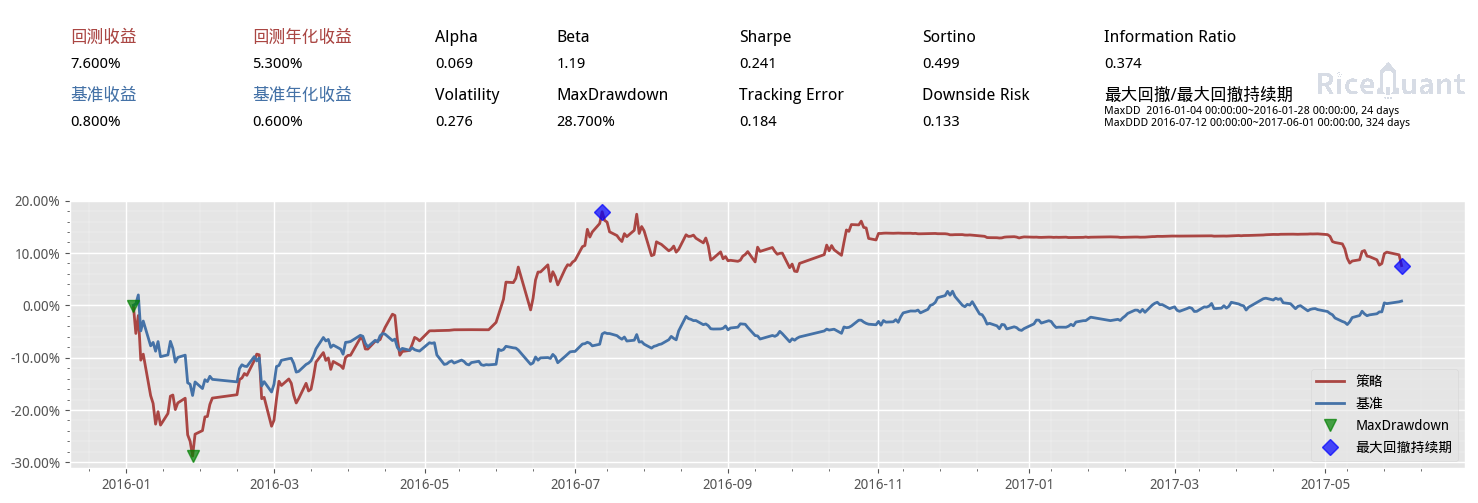

[2017-09-26 09:36:10.360990] DEBUG: system_log: 策略运行成功，正常退出


In [23]:
from rqalpha_plus.api import *
from rqalpha_plus import run_func
###############################################################################################################################################
# 可以自己import我们平台支持的第三方python模块，比如pandas、numpy等。
import numpy as np
import pandas as pd
from pandas import *
import datetime as dt

# 在这个方法中编写任何的初始化逻辑。context对象将会在你的算法策略的任何方法之间做传递。
def init(context):
    context.now
    context.last_month = 13
    context.buy_stocks = []

# before_trading此函数会在每天策略交易开始前被调用，当天只会被调用一次
def before_trading(context):
    # 是否调仓，每日更新为不调仓
    context.change = False
    context.buy_stocks = []
    if context.now.month == context.last_month:
        return None
    context.last_month = context.now.month
    aera = fin_alpha_area(context)
    ready_stocks = fin_stocks(aera,context)
    #stocks = get_buy_stock(ready_stocks,context)
    context.buy_stocks = get_my_stocks(ready_stocks,context)
    context.change = True


# 你选择的证券的数据更新将会触发此段逻辑，例如日或分钟历史数据切片或者是实时数据切片更新
def handle_bar(context, bar_dict):
    if context.change != True:
        return None
    for stock in context.portfolio.stock_account.positions:
        if stock not in context.buy_stocks:
            order_target_percent(stock,0)
    
    for stock in context.buy_stocks:
        order_target_percent(stock,1/len(context.buy_stocks))
        
# 彼得林奇
def get_my_stocks(stocks,context):
    df = get_fundamentals(
        query(fundamentals.financial_indicator.cash_flow_from_operations_per_share
        ).filter(
            fundamentals.financial_indicator.debt_to_asset_ratio <= 100 # 资产负债率小于等于25%
        ).filter(
            fundamentals.financial_indicator.cash_flow_from_operations_per_share > 0 # 每股净现金大于0
        ).filter(
            fundamentals.financial_indicator.annual_return_on_equity > 20 # 当前股价与每股自由现金流量比小于11
        ).filter( 
            financials.stockcode.in_(stocks))
    ).T
    if len(df.index) <= 2:
        return ['000012.XSHG']
    df = df.sort_values('cash_flow_from_operations_per_share',ascending=False)
    buy_stocks = [stock for stock in df.index if is_suspended(stock) != True]
    return buy_stocks[:20]
    
# 横盘的10支股票
def get_cheap_stocks(stocks,context):
    start_date = (context.now-dt.timedelta(days = 90)).strftime("%Y-%m-%d")
    end_date = (context.now-dt.timedelta(days = 1)).strftime("%Y-%m-%d")
    price = get_price(stocks,start_date = start_date,end_date = end_date,fields = ['close'],adjust_type='pre')
    price =np.abs(price.iloc[0,:]/price.iloc[-1,:]-1)
    price = price.sort_values(ascending=True)
    buy_stocks = [stock for stock in price.index if is_suspended(stock) != True]
    
    return buy_stocks[-20:-10]

# 买入roe最大的10支股票
def get_buy_stock(stocks,context):
    value = get_fundamentals( 
        query( 
            fundamentals.financial_indicator.annual_return_on_equity, 
        ).filter(financials.stockcode.in_(stocks)),
            entry_date = context.now - dt.timedelta(days = 1),interval = '1d', report_quarter = False).T
    value.sort_values('annual_return_on_equity',ascending=False, inplace=True)
    buy_stocks = [stock for stock in value.index if is_suspended(stock) != True]
    
    return buy_stocks[0:int(len(buy_stocks)/3)]
    

# after_trading函数会在每天交易结束后被调用，当天只会被调用一次
def after_trading(context):
    pass

def fin_stocks(aera,context):
    # 用查询一年前所有股票的基本面信息
    all_stocks_value = get_fundamentals( 
        query( 
            fundamentals.eod_derivative_indicator.pb_ratio, 
            fundamentals.eod_derivative_indicator.market_cap 
        ),
            entry_date = context.now - dt.timedelta(days = 1),interval = '1d', report_quarter = False).T
    all_stocks_value.dropna(how = 'any',inplace = True)
    all_stocks_value['bp_ratio'] = 1/all_stocks_value['pb_ratio']
    del all_stocks_value['pb_ratio']
    
    # 对股票进行分组
    calue_copy = all_stocks_value.iloc[:,:]
    lengh = len(all_stocks_value.index)
    all_stocks_value = all_stocks_value.sort_values('market_cap') #市值升序排布
    S = all_stocks_value.index[:int(lengh/2)]
    B = all_stocks_value.index[int(lengh/2):]
    all_stocks_value = all_stocks_value.sort_values('bp_ratio') #净市率升序排列
    L = all_stocks_value.index[:int(lengh*0.3)]
    M = all_stocks_value.index[int(lengh*0.3):int(lengh*0.7)]
    H = all_stocks_value.index[int(lengh*0.7):]
    
    # 分为6类别
    portfolio = pd.Series()
    portfolio['SL'] = list(set(S).intersection(set(L)))
    portfolio['SM'] = list(set(S).intersection(set(M)))
    portfolio['SH'] = list(set(S).intersection(set(H)))
    portfolio['BL'] = list(set(B).intersection(set(L)))
    portfolio['BM'] = list(set(B).intersection(set(M)))
    portfolio['BH'] = list(set(B).intersection(set(H)))
    
    return portfolio[aera]

def fin_alpha_area(context):
    last_year = context.now - dt.timedelta(days = 150)
    yesterday = context.now - dt.timedelta(days = 1)
    
    # 得到所有的股票
    sz = index_components('399107.XSHE')
    sh = index_components('000002.XSHG')
    sz.extend(sh)
    all_stocks = sz.copy()
    
    # 拿到所有股票日收益率变动
    all_price = get_price(all_stocks,start_date=last_year-dt.timedelta(days =1), end_date=yesterday,fields = 'close')
    all_price = ((all_price.T).dropna(how = 'any',inplace = False)).T
    all_stocks = all_price.columns.values
    all_price_change_rate = all_price.pct_change().dropna(how = 'any',inplace = False)
    
    # 用查询一年前所有股票的基本面信息
    all_stocks_value = get_fundamentals( 
        query( 
            fundamentals.eod_derivative_indicator.pb_ratio, 
            fundamentals.eod_derivative_indicator.market_cap 
        ).filter( 
            financials.stockcode.in_(all_stocks)),
            entry_date = last_year,interval = '1d', report_quarter = False).T
    all_stocks_value.dropna(how = 'any',inplace = True)
    all_stocks_value['bp_ratio'] = 1/all_stocks_value['pb_ratio']
    del all_stocks_value['pb_ratio']
    
    # 对股票进行分组
    calue_copy = all_stocks_value.iloc[:,:]
    lengh = len(all_stocks_value.index)
    all_stocks_value = all_stocks_value.sort_values('market_cap') #市值升序排布
    S = all_stocks_value.index[:int(lengh/2)]
    B = all_stocks_value.index[int(lengh/2):]
    all_stocks_value = all_stocks_value.sort_values('bp_ratio') #净市率升序排列
    L = all_stocks_value.index[:int(lengh*0.3)]
    M = all_stocks_value.index[int(lengh*0.3):int(lengh*0.7)]
    H = all_stocks_value.index[int(lengh*0.7):]
    
    # 分为6类别
    portfolio = {}
    portfolio['SL'] = list(set(S).intersection(set(L)))
    portfolio['SM'] = list(set(S).intersection(set(M)))
    portfolio['SH'] = list(set(S).intersection(set(H)))
    portfolio['BL'] = list(set(B).intersection(set(L)))
    portfolio['BM'] = list(set(B).intersection(set(M)))
    portfolio['BH'] = list(set(B).intersection(set(H)))
    
    # 计算每类平均收益
    return_ = pd.Series()
    for i in portfolio:
        return_[i] = np.array(all_price_change_rate[portfolio[i]]).mean()
    return_.sort_values(ascending=False, inplace=True)
    
    #print(return_)
    
    return return_.index[0]

config = {
  "base": {
    "start_date": "2016-01-01",
    "end_date": "2017-06-01",
    "benchmark": "000300.XSHG",
    'accounts': {
                 'stock': 100000},
  },
  "extra": {
    "log_level": "verbose",
  },
  "mod": {
    "sys_analyser": {
      "enabled": True,
      "plot": True
    }
  }
}

# 您可以指定您要传递的参数
run_func(init=init, before_trading=before_trading, handle_bar=handle_bar, config=config)

from rqdatac import *

## 第三节：Fama-French因子风险暴露Factor Risk Exposure

<font size = 3 face = '宋体'>
&nbsp;&nbsp;运用多因子模型分析一个组合中风险和收益的来源，多因子模型对收益的分解如下：

$$R_i = a_i + b_{i1} F_1 + b_{i2} F_2 + \ldots + b_{iK} F_K + \epsilon_i$$ 

&nbsp;&nbsp;在风险分析中，我们常常对超额收益（相对基准的收益情况）建模，风险用超额收益（active Return）的标准误来体现。也叫做tracking error。

例如因子对超额收益风险平方的边际贡献（factors' marginal contributions to active risk squared，*FMCAR* ） 对于因子 $j$, 这个指标是这样计算的：

$$ \text{FMCAR}_j = \frac{b_j^a \sum_{i=1}^K b_i^a Cov(F_j, F_i)}{(\text{Active risk})^2} $$

&nbsp;&nbsp;$b_i^a$ 是组合对因子$i$的风险暴露。这项指标告诉我们了，假设其他条件不变，暴露在因子$j$下我们增加了多少风险。
</font>

<font size = 3 face = '宋体'>
&nbsp;&nbsp;在上文的基础商，我们计算SMB和HML的累计收益率


In [24]:
SMB_cu = pd.Series(index = SMB.index)
HML_cu = SMB_cu.copy()

for i in range(len(SMB)):
    if i == 0:
        print("ok")
        SMB_cu[i] = 1+SMB[i]
        HML_cu[i] = 1+HML[i]
    else:
        SMB_cu[i] = SMB_cu[i-1]*(SMB[i]+1)
        HML_cu[i] = HML_cu[i-1]*(HML[i]+1)
df = pd.DataFrame()
df['SMB_cu'] = SMB_cu
df['HML_cu'] = HML_cu
df.iplot(kind='scatter', filename='累计收益率')

ok


![Markdown](http://i2.kiimg.com/1949/aad688c2114dc315.png)

<font size = 3 face = '宋体'>
&nbsp;&nbsp;SMB(t)是一个买入小盘股卖出大盘股的组合收益率。HML(t)是一个买入高净市率股票(低pb)卖空低净市率(高pb)股票的投资组合收益率。
</font>

### 计算风险暴露程度
<font size = 3 face = '宋体'>&nbsp;&nbsp;下面我们运用多因素模型和线性回归工具来计算某只股票的回报率相对于这些因子的风险暴露程度。我们以某个资产组合的超额收益作为被解释变量，对因子做回归，一个因子对超额收益贡献越大，那么这个资产组合的超额收益对于该因子的暴露程度也越高。我们前面已经存在了一个小市值的股票组合了
</font>

In [25]:
def FMACR(SMB,HML,Rb,Rp):
    X = pd.DataFrame()
    X['Rb'] = np.array(Rb)
    X['SMB'] = np.array(SMB)
    X['HML'] = np.array(HML)
    X = sm.add_constant(X)
    Y = np.array(Rp)
    est=sm.OLS(Y,X).fit()
    active = Rp-est.params['Rb']*Rb
    
    cov = np.cov(SMB, HML)
    ar_squared = (active.std())**2
    SMB_fmcar = (est.params['SMB']*(est.params['HML']*cov[0,1] + est.params['SMB']*cov[0,0]))/ar_squared
    HML_fmcar = (est.params['HML']*(est.params['SMB']*cov[0,1] + est.params['HML']*cov[1,1]))/ar_squared
    
    return SMB_fmcar,HML_fmcar

fmcar = pd.DataFrame(index = Rp.index[30:],columns = ['SMB_fmcar','HML_fmcar'])
for i in range(30,len(Rp)):
    fmcar['SMB_fmcar'][i-30],fmcar['HML_fmcar'][i-30] = FMACR(SMB.iloc[i-30:i],HML.iloc[i-30:i],Rb.iloc[i-30:i],Rp.iloc[i-30:i])
fmcar.iplot(kind='scatter', filename='FMACR')

![Markdown](http://i2.kiimg.com/1949/5a67d3e94c9e7724.png)

<font size = 3 face = '宋体'>&nbsp;&nbsp;了解历史数据中组合对各个因子的暴露程度是很有趣的，但只有将它用在对未来收益率的预测上时，它才有用武之地。但我们不是总能够放心地认为未来的情况与现在相同，由于随时间会变化，对风险暴露程度取平均值也很容易出现问题。我们可以给均值加上一个置信区间，但只有当收益率的分布是正态分布或者表现很稳健才行。我们来看看Jarque-Bera测验的结果。

In [26]:
data = [go.Histogram(x=np.array(fmcar['SMB_fmcar'])),go.Histogram(x=np.array(fmcar['HML_fmcar']))]
data[0].name = 'SMB_fmcar'
data[1].name = 'HML_fmcar'
py.iplot(data, filename='SMB_FMCAR')

![Markdown](http://i4.piimg.com/1949/98e20a496553f4e4.png)

In [27]:
from statsmodels.stats.stattools import jarque_bera
JB_SMB, _, _, _ = jarque_bera(fmcar['SMB_fmcar'])
JB_HML, _, _, _ = jarque_bera(fmcar['HML_fmcar'])

print ('JB SMB_FMCAR is normally distributed', JB_SMB)
print ('JB HML_FMCAR is normally distributed', JB_HML)

JB SMB_FMCAR is normally distributed 4.62824274098244
JB HML_FMCAR is normally distributed 0.060634537854736326


## 第四节：Fama五因素模型
<font face = '宋体' size = 3>
&nbsp;&nbsp;由Eugene F. Fama和Kenneth R. French撰写Journal of Financial Economics2015年第4期论文“A five-factor asset pricing model”对原有的Fama-French（1993）三因素模型进行了改进，在原有的市场、公司市值（即SML，small minus large）以及账面市值比（即HML，high minus low）三因子的基础上，加入了盈利能力（profitability）因子（即RMW，robust minus weak）和投资模式（investment patterns）因子（即CMA，conservative minus aggressive），从而能够更好地解释股票横截面收益率的差异。
对于这个新的模型，其基本特性和一些要素总结如下：
- 定义盈利能力因子（profitability）为高/低盈利股票投资组合的回报之差（Robust Minus Weak）
- 定义投资模式因子（investment pattern）为高/低投资比例公司股票投资组合的回报之差（Conservative Minus Aggressive）
- 五因子模型比三因子模型能更好地解释股票的回报
- 五因子模型存在的问题是对于高投资比例低盈利小盘股的回报解释不甚理想
- 加上了盈利能力和投资模式两个新因子之后，原先的价值因子似乎变得多余

In [28]:
# 取2016-05-15的估值数据作为SMB和HML的计算标准
all_stocks_value = get_fundamentals(
    query(
        fundamentals.eod_derivative_indicator.pb_ratio,
        fundamentals.eod_derivative_indicator.market_cap, 
        fundamentals.financial_indicator.annual_return_on_equity, 
        fundamentals.financial_indicator.inc_total_asset)
    , '2016-05-15', interval = '1d' ,report_quarter = False)
all_stocks_value = all_stocks_value.major_xs(all_stocks_value.major_axis[0])
all_stocks_value['bp_ratio'] = 1/all_stocks_value['pb_ratio']
del all_stocks_value['pb_ratio']
all_stocks_value = all_stocks_value.dropna(how = 'any')
all_stocks_value.head()

,market_cap,annual_return_on_equity,inc_total_asset,bp_ratio
000005.XSHE,7.47327e+09,-2.3836,-3.7934,0.152798
600602.XSHG,1.26845e+10,3.6792,-2.5571,0.262
600651.XSHG,1.02955e+10,2.5172,40.3337,0.317914
600652.XSHG,1.14247e+10,1.5756,3.2331,0.182093
600654.XSHG,2.46982e+10,7.4944,-7.3252,0.119852


In [29]:
# 拿到所有股票的日收益率数据
all_price_change_rate = get_price_change_rate(list(all_stocks_value.index),start_date='20160514', end_date='20170515')
all_price_change_rate.head()

order_book_id,000001.XSHE,000002.XSHE,000004.XSHE,000005.XSHE,000006.XSHE,000007.XSHE,000008.XSHE,000009.XSHE,000010.XSHE,000011.XSHE,...,603968.XSHG,603969.XSHG,603979.XSHG,603988.XSHG,603989.XSHG,603993.XSHG,603996.XSHG,603997.XSHG,603998.XSHG,603999.XSHG
date,,,,,,,,,,,,,,,,,,,,,
2016-05-16,0.000966,0.0,0.0,-0.004250,0.015193,0.0,0.002573,0.027687,0.013698,0.010726,...,0.021104,0.006473,0.011156,0.018755,0.017122,0.0,-0.005135,0.036574,0.022205,0.025498
2016-05-17,-0.005792,0.0,0.0,-0.004267,0.004082,0.0,-0.023952,-0.003169,0.001228,0.024489,...,-0.010333,-0.008040,-0.008385,-0.023413,-0.002619,0.0,0.059784,-0.013783,-0.014982,-0.002122
2016-05-18,0.000000,0.0,0.0,-0.044286,-0.025745,0.0,-0.041192,-0.037362,-0.058895,-0.035858,...,-0.083936,-0.030794,-0.027147,-0.041187,-0.037884,0.0,-0.095374,-0.036890,-0.062358,-0.035855
2016-05-19,-0.004854,0.0,0.0,0.004485,0.001391,0.0,0.003656,0.002478,-0.006519,0.001655,...,-0.001315,0.010869,0.001830,0.000854,0.005848,0.0,0.100046,0.005802,0.008111,0.006618
2016-05-20,0.004878,0.0,0.0,0.013393,0.002778,0.0,-0.002732,0.009884,0.001313,0.005774,...,-0.034679,0.010051,0.009589,-0.008115,0.021707,0.0,0.099917,0.017312,0.006437,0.012523


In [52]:
# 去除nan
test = all_price_change_rate.dropna(how = 'any',axis=1)
test.head()

order_book_id,000001.XSHE,000002.XSHE,000004.XSHE,000005.XSHE,000006.XSHE,000007.XSHE,000008.XSHE,000009.XSHE,000010.XSHE,000011.XSHE,...,603968.XSHG,603969.XSHG,603979.XSHG,603988.XSHG,603989.XSHG,603993.XSHG,603996.XSHG,603997.XSHG,603998.XSHG,603999.XSHG
date,,,,,,,,,,,,,,,,,,,,,
2016-05-16,0.000966,0.0,0.0,-0.004250,0.015193,0.0,0.002573,0.027687,0.013698,0.010726,...,0.021104,0.006473,0.011156,0.018755,0.017122,0.0,-0.005135,0.036574,0.022205,0.025498
2016-05-17,-0.005792,0.0,0.0,-0.004267,0.004082,0.0,-0.023952,-0.003169,0.001228,0.024489,...,-0.010333,-0.008040,-0.008385,-0.023413,-0.002619,0.0,0.059784,-0.013783,-0.014982,-0.002122
2016-05-18,0.000000,0.0,0.0,-0.044286,-0.025745,0.0,-0.041192,-0.037362,-0.058895,-0.035858,...,-0.083936,-0.030794,-0.027147,-0.041187,-0.037884,0.0,-0.095374,-0.036890,-0.062358,-0.035855
2016-05-19,-0.004854,0.0,0.0,0.004485,0.001391,0.0,0.003656,0.002478,-0.006519,0.001655,...,-0.001315,0.010869,0.001830,0.000854,0.005848,0.0,0.100046,0.005802,0.008111,0.006618
2016-05-20,0.004878,0.0,0.0,0.013393,0.002778,0.0,-0.002732,0.009884,0.001313,0.005774,...,-0.034679,0.010051,0.009589,-0.008115,0.021707,0.0,0.099917,0.017312,0.006437,0.012523


In [31]:
stock_need_drop = list(set(all_price_change_rate.columns).difference(set(test.columns)))
stock_need_drop

['000748.XSHE', '600005.XSHG']

In [32]:
# 在估值数据中将上述两支股票删除
all_stocks_value = all_stocks_value.T
for stock in stock_need_drop:
    del all_stocks_value[stock]
all_stocks_value = all_stocks_value.T

In [33]:
short = int(len(all_stocks_value.index)*0.3)
long = int(len(all_stocks_value.index)*0.7)

all_stocks_value.sort_values('market_cap',ascending=True, inplace=True)
SMB = all_price_change_rate[all_stocks_value.index[:short]].T.mean()-all_price_change_rate[all_stocks_value.index[long:]].T.mean()

all_stocks_value.sort_values('bp_ratio',ascending=False, inplace=True)
HML = all_price_change_rate[all_stocks_value.index[:short]].T.mean()-all_price_change_rate[all_stocks_value.index[long:]].T.mean()

all_stocks_value.sort_values('annual_return_on_equity',ascending=False, inplace=True)
RMW = all_price_change_rate[all_stocks_value.index[:short]].T.mean()-all_price_change_rate[all_stocks_value.index[long:]].T.mean()

all_stocks_value.sort_values('inc_total_asset',ascending=False, inplace=True)
CMA = all_price_change_rate[all_stocks_value.index[:short]].T.mean()-all_price_change_rate[all_stocks_value.index[long:]].T.mean()

In [34]:
SMB_cu = pd.Series(index = SMB.index)
HML_cu = SMB_cu.copy()
RMW_cu = SMB_cu.copy()
CMA_cu = SMB_cu.copy()
 
for i in range(len(SMB)):
    if i == 0:
        print("ok")
        SMB_cu[i] = 1+SMB[i]
        HML_cu[i] = 1+HML[i]
        RMW_cu[i] = 1+RMW[i]
        CMA_cu[i] = 1+CMA[i]
    else:
        SMB_cu[i] = SMB_cu[i-1]*(SMB[i]+1)
        HML_cu[i] = HML_cu[i-1]*(HML[i]+1)
        RMW_cu[i] = RMW_cu[i-1]*(RMW[i]+1)
        CMA_cu[i] = CMA_cu[i-1]*(CMA[i]+1)
df = pd.DataFrame()
df['SMB_cu'] = SMB_cu
df['HML_cu'] = HML_cu
df['RMW_cu'] = RMW_cu
df['CMA_cu'] = CMA_cu
df.iplot(kind='scatter', filename='累计收益率')

ok


![Markdown](http://i4.piimg.com/1949/84599782272c72ab.png)

<font face = '宋体' size = 3>
&nbsp;&nbsp;对比上述的图，我们可以发现，同样是SMB平均仓位买入和按庄重买入有完全不同效果，按权重买入，我们在大市值的公司暴露度较好，而平均仓位买入在17年4月份，我们面临一个极大的回调，与此相对因的低pb的公司则收益见好。当然，使用模型不必拘谨于模型本身。

### 附录：<span id = '附录OLS指标'></span>
<font face = '宋体' size = 3>
Dep.variable: 因变量，随自变量的变动而变动  

Model: 模型类型（此处为线性回归模型)  

Method: 参数估计方法（此处为最小二乘法）  

No.observation:样本数量  

Df.residuals:残差的自由度，也就是说当用样本来估计整体残差的时候，样本中独立能自由变化的数据的个数  

Df.model: 统计模型的自由度，也就等于能自由取值的自变量的个数  

Covariance type: 协方差类型  

R-squared: 决定系数，即R^2，意味着模型的拟合度的好坏, R-squared误差取值范围为0到1，这个值越接近1说明模型的拟合度越好。 $R-squared=SSR/SST$(SSR是预测数据与原始数据均值之差的平方和，SST是原始数据和均值之差的平方和)  

Adj.R-squared:调整后的决定系数，$$Adj.R-squared=1-\frac{(1-R^2)(n-1)}{n-k-1}$$  （$n$为自变量数目，$k$为解释变量的数目）  


F-statistique: F 检验统计量，是模型总体显著性检验的指标,它越大,模型越好。$F=\frac{R^2/k}{(1-R^2)/(n-k-1)}$  


Prob(F-statistique): F检验统计量对应的概率  

Log likelihood: 对数似然比检验的值，值越高，说明模型越精准。其公式为$F=\frac{-n}{2}log(2п) - \frac{n}{2} logσ^2- \frac{n}{2}$  

AIC: 赤池信息量即Akaike information criterion，是衡量统计模型拟合优良性的一种标准。  
在一般的情况下，AIC可以表示为： $AIC=2k-2ln(L)$，其中k是参数数量，L是似然函数。假设条件是模型的误差服从独立正态分布。 让n为观察数，SSR(SUM SQAURE OF RESIDUE)为残差平方和，那么AIC变为： $AIC=2k+nln(SSR/n)$。增加自由参数的数目提高了拟合的优良性，AIC鼓励数据拟合的优良性但是尽量避免出现过度拟合(Overfitting)的情况。所以优先考虑的模型应是AIC值最小的那一个。

BIC: Bayesian information criterion，贝叶斯信息度量。 $BIC=kln(n)-2ln(L)$。其中n是模型中未知参数的数量。 BIC相比AIC在大数据量时对模型参数惩罚得更多，导致BIC更倾向于选择参数少的简单模型。  
Coef: 回归系数的估计值。 $β^=（X^T X）^{-1}$ $X^TY$  

Std err: 回归系数估计量的标准差  

t: T检验的统计量，即样本平均数与总体平均数的离差统计量。因为样本x符合正太分布，那么 $t=\frac{X ̅-μ}{σ/√(n-1)}$  符合自由度为n-2的T分布,其中t为样本平均数与总体平均数的离差统计量，X ̅为样本平均数，μ为总体平均数，σ为样本标准差，n为样本容量.。当t大于自由度为n-2的T分别的临界分位点时，我们拒绝零假设  

P>|t|: t对应的T分布的概率，当此概率小于临界值的概率（通常是5%），我们拒绝零假设  

[95% conf, inter]: 选择95%的置信度时，拒绝零假设的置信区间。也就是拒绝零假设时样本平均值的范围。  

Omnibus: 模型的总的全局检验，为似然比检验.  

Prob(omnibus):  

Skew: 偏度系数。当分布对称时，偏度系数为0.当偏度系数为正值，可以判断为右偏。反之判断为左偏。 $Skew=\frac{1}{n-1}$ $\sum_{i=1}^n\frac{(x_i-X ̅ )^3}{S^3}$，其中S为标准差  

Kurtosis: 峰度系数。是对数据分布平峰或尖峰程度的测度。峰度是针对正态分布而言的。峰度系数为0，表明数据为正态分布。若峰度系数大于0，则数据为尖峰分布；否则为平峰分布。$Kurtosis=\frac{1}{n-1}$ $\sum_{i=1}^n\frac{(x_i-X ̅ )^4}{S^4}-3$  
Durbin-Watson: 检验残差中是否存在自相关。自相关表示相邻观测值是相关的。 如果它们是相关的，那么最小二乘回归低估了系数的标准误；此时，您的预测变量似乎非常显著，其实可能是不显著的。例如，来自每日股票价格数据回归的残差可能取决于以前的观测值，因为前一天的股票价格会影响第二天的价格。 Durbin-Watson 统计量以观测值的顺序（行）为条件。Minitab 假设观测值遵循有意义的顺序（如时间顺序）。Durbin-Watson 统计量确定相邻误差项之间的相关性是否为零。要从检验中得出结论，需要将显示的统计量与表中的上下限进行比较。如果 D > 上限，表示不存在相关性；如果 D < 下限，表示存在正相关性；如果 D 在上下限之间，则无法从检验中得出结论。  

Jarque-Bera(JB): Jarque-Bera检验基于数据样本的偏度和峰度，评价给定数据服从未知均值和方差正态分布的假设是否成立。  
$JB=\frac{n-k}{6}$($S^2$+$\frac{（k-3）^2}{4}$) ，其中n为样本容量，k为自由度， S为标准差。  

Prob(JB)： JB统计量的相伴概率，若小于设定的概率水平，则拒绝原假设，不认样本概率服从正态分布。

</font>
